In [6]:
import logging
import os
import re

import pandas as pd

from pathlib import Path

%load_ext autoreload
%autoreload 2

# Disable logging of the program in the notebook
os.environ["LOGLEVEL"] = "CRITICAL"

logging.basicConfig()
logging.root.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('__main__')
logger.setLevel(os.environ.get("LOGLEVEL", logging.FATAL))

pybooklogger = logging.getLogger('pybook')
pybooklogger.setLevel(logging.DEBUG)

%aimport setup

from setup import *
from tad_help import TadRunner

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Track Layout
Calculate the layout of the dutch railway system


In [12]:
layout_file =   "../data/prorail/parsed/netherlands-schiphol.json"
layout = Layout(layout_file)

In [2]:
scenario_files = Path("../data/prorail/scenarios/TAD/Zwolle")
save_dir = r"C:\Users\erick\Documents\uni\Thesis\delay-replannning\experiments\results\tad"

..\data\prorail\scenarios\TAD\Zwolle\2025-07-21_1.json


INFO:pybook.setup:Setting up experiment {'start_time': np.float64(660.0), 'origin': 'AMF|2', 'destination': 'SWK|2', 'filter_agents': np.int64(36), 'metadata': {'offset': 0, 'color': 'Red', 'label': 'No flexibility'}, 'velocity': 38.888888888888886, 'max_buffer_time': 0, 'use_recovery_time': False}
INFO:pybook.setup:Setting up experiment {'start_time': np.float64(660.0), 'origin': 'AMF|2', 'destination': 'SWK|2', 'max_buffer_time': 900, 'use_recovery_time': True, 'filter_agents': np.int64(36), 'metadata': {'color': 'Blue', 'label': 'Recovery time', 'offset': 0}, 'velocity': 38.888888888888886}
DEBUG:pybook.setup:Running: ../search/buildDir/atsipp.exe --start r-Amf|5510 --goal r-Swk|22 --edgegraph output --search repeat --startTime 660.0
DEBUG:pybook.setup:repeat output: ['<0,inf,inf,inf> <-inf,683.729,3510.81,3510.81>', '<683.729,inf,inf,inf> <-inf,729.062,3510.81,3510.81>', '<729.062,inf,inf,inf> <729.062,853.359,3510.81,3635.11>', '<-inf,729.062,3510.81,3510.81> <729.062,853.359,3510

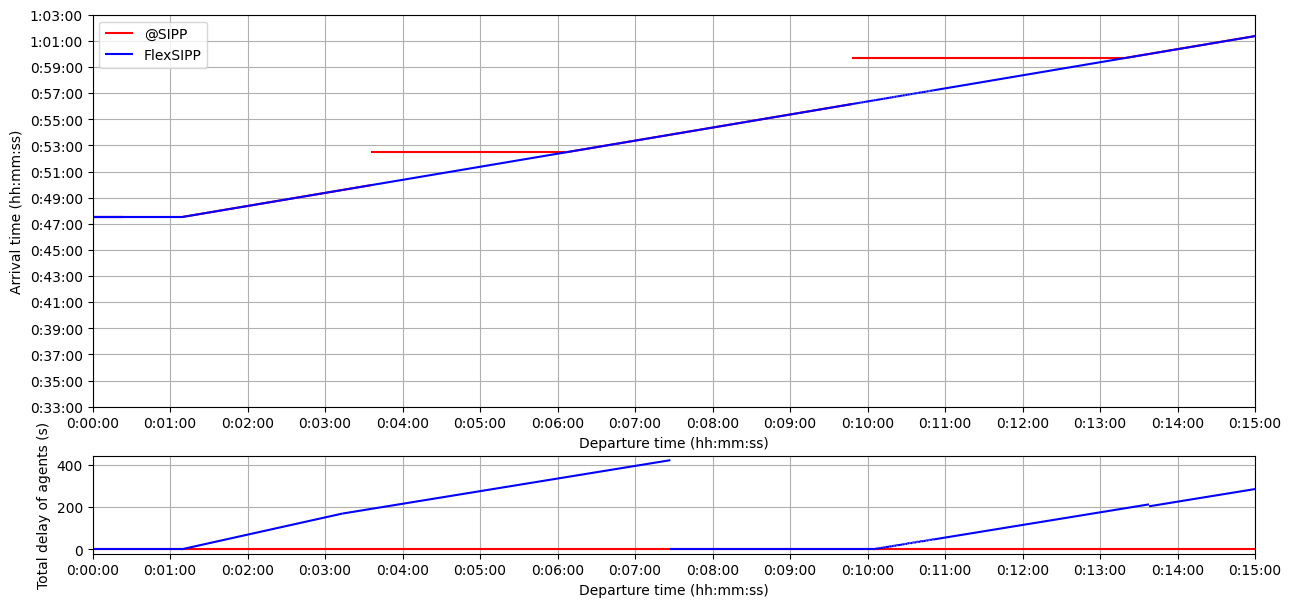

INFO:pybook.setup:Plotting <setup.Experiment object at 0x00000224BC4A0730>
INFO:pybook.setup:Plotting <setup.Experiment object at 0x00000224BC4A0730>


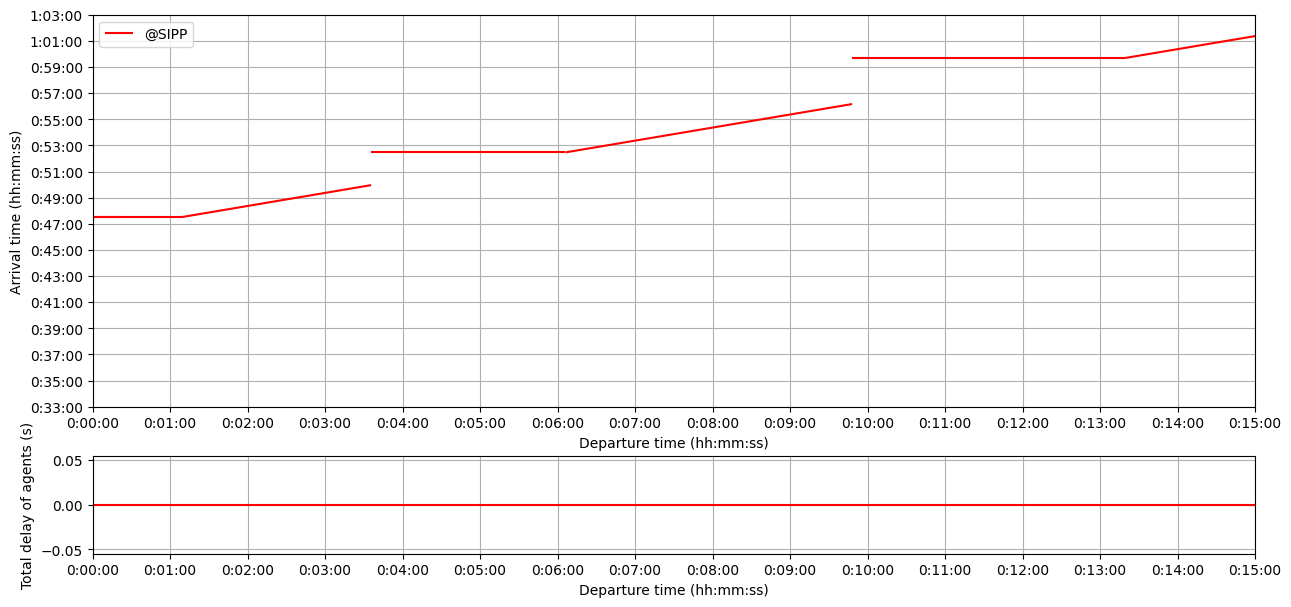

INFO:pybook.setup:Plotting <setup.Experiment object at 0x00000224BDE5AAF0>
INFO:pybook.setup:Plotting <setup.Experiment object at 0x00000224BDE5AAF0>


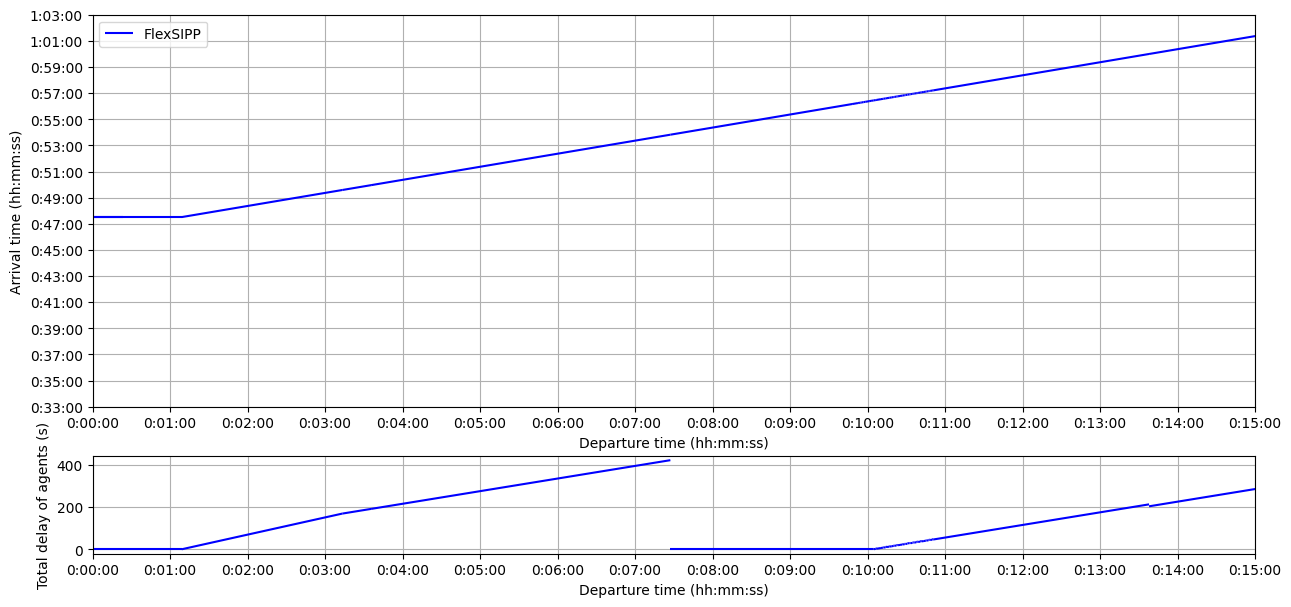

..\data\prorail\scenarios\TAD\Zwolle\2025-07-21_2.json
single positional indexer is out-of-bounds
..\data\prorail\scenarios\TAD\Zwolle\2025-07-21_3.json


INFO:pybook.setup:Setting up experiment {'start_time': np.float64(1620.0), 'origin': 'AMF|2', 'destination': 'SWK|2', 'filter_agents': np.int64(21), 'metadata': {'offset': 0, 'color': 'Red', 'label': 'No flexibility'}, 'velocity': 38.888888888888886, 'max_buffer_time': 0, 'use_recovery_time': False}
INFO:pybook.setup:Setting up experiment {'start_time': np.float64(1620.0), 'origin': 'AMF|2', 'destination': 'SWK|2', 'max_buffer_time': 900, 'use_recovery_time': True, 'filter_agents': np.int64(21), 'metadata': {'color': 'Blue', 'label': 'Recovery time', 'offset': 0}, 'velocity': 38.888888888888886}
DEBUG:pybook.setup:Running: ../search/buildDir/atsipp.exe --start r-Amf|5510 --goal r-Swk|22 --edgegraph output --search repeat --startTime 1620.0
DEBUG:pybook.setup:repeat output: ['<0,inf,inf,inf> <-inf,1689.06,4470.81,4470.81>', '<1689.06,inf,inf,inf> <1689.06,1813.36,4470.81,4595.11>', '<1813.36,inf,inf,inf> <-inf,1813.36,4595.26,4595.26>', '<1689.06,1813.36,4470.81,4595.11> <-inf,1813.36,4

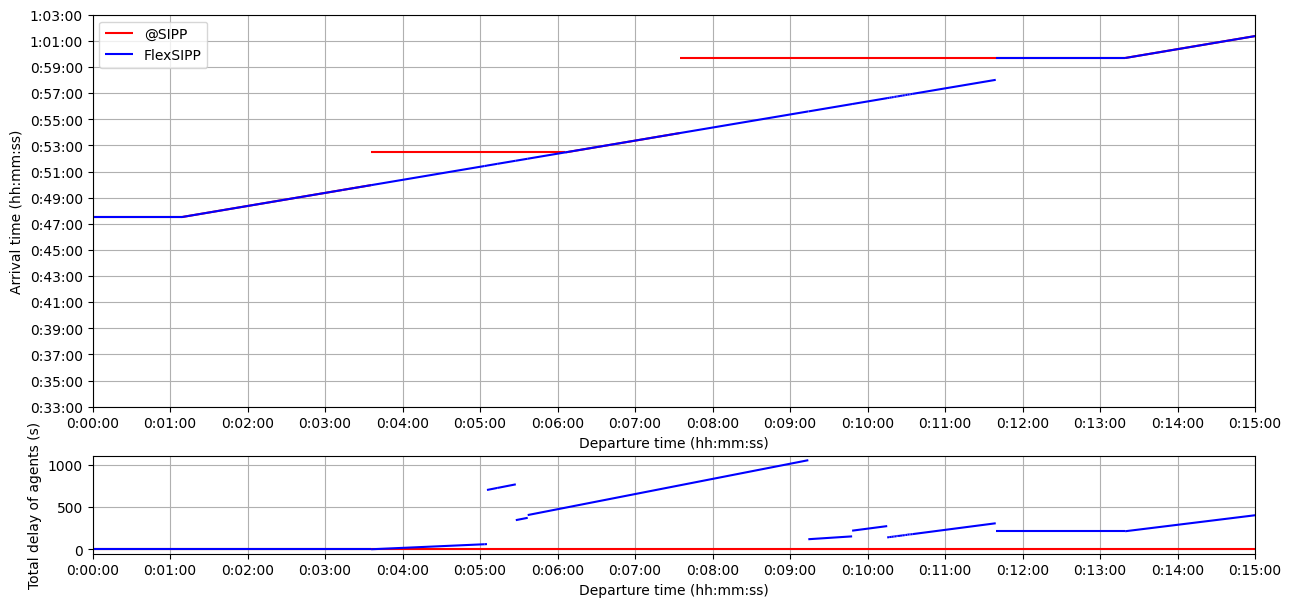

INFO:pybook.setup:Plotting <setup.Experiment object at 0x000002249C9299D0>
INFO:pybook.setup:Plotting <setup.Experiment object at 0x000002249C9299D0>


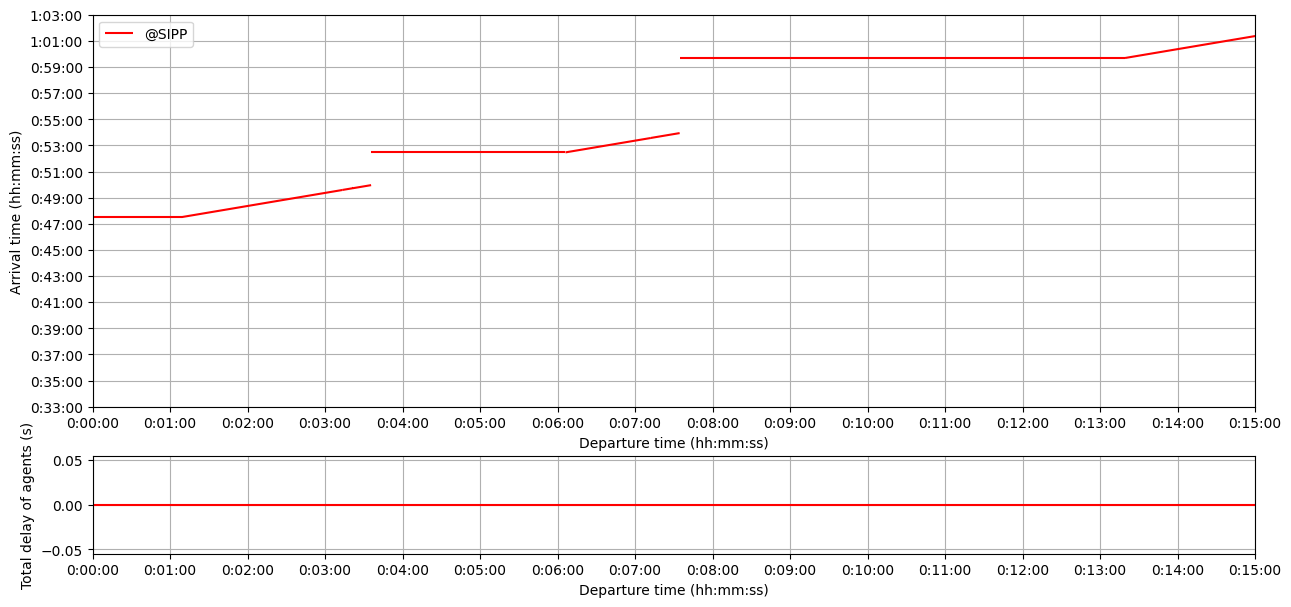

INFO:pybook.setup:Plotting <setup.Experiment object at 0x000002249C929370>
INFO:pybook.setup:Plotting <setup.Experiment object at 0x000002249C929370>


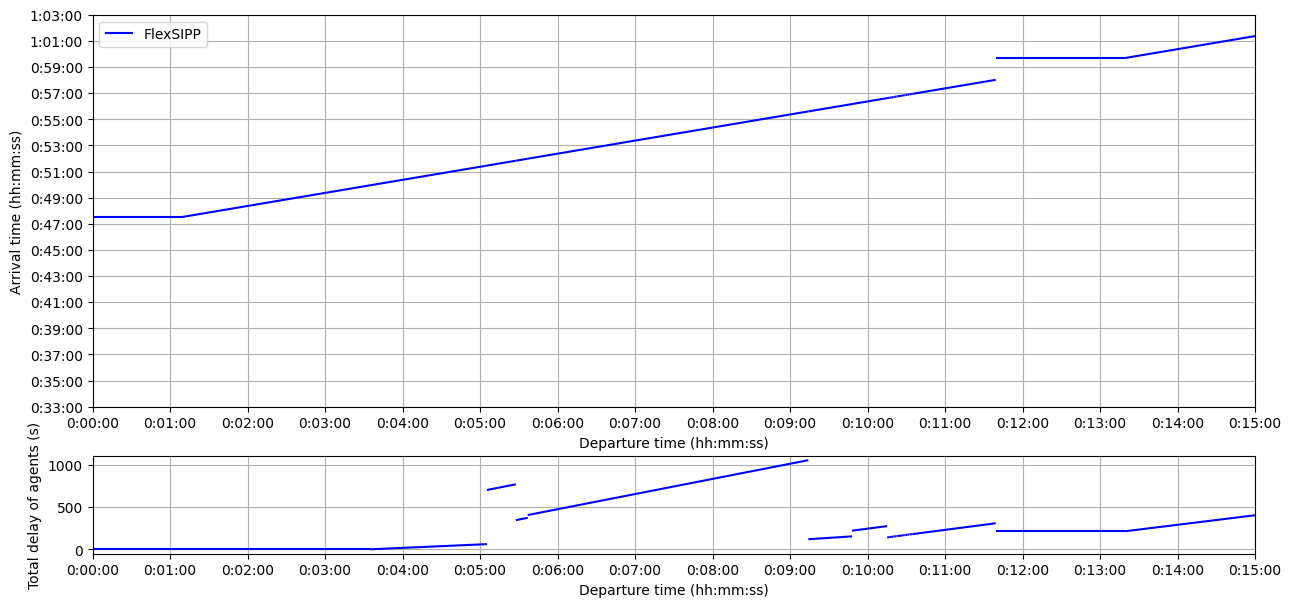

..\data\prorail\scenarios\TAD\Zwolle\2025-07-22_1.json
nan|1 is not a station


In [25]:
path_data = []
time_data = []
comp_data = []
for scenario_file in os.listdir(scenario_files):
# for scenario_file in ["2025-07-21_1.json", "2025-07-21_2.json", "2025-07-21_3.json"]:
    try:
        tad_exp = TadRunner(layout, scenario_files / scenario_file, save_dir)
        experiments = tad_exp.run("600", "o", "AMF", "SWK", default_direction=1)
        experiments[0].metadata = {'color': 'Red',   'label': '@SIPP',    'offset': 0, 'linestyle': 3}
        experiments[1].metadata = {'color': 'Blue',  'label': 'FlexSIPP', 'offset': 0, 'linestyle': 3}

        tad_exp.plot(experiments, save="600o-ZL", y_offset=-1200, include_expected_arrival=False)
        tad_exp.plot([experiments[0]], save="600o-ZL/atsipp", y_offset=-1200, include_expected_arrival=False)
        tad_exp.plot([experiments[1]], save="600o-ZL/flexsipp", y_offset=-1200, include_expected_arrival=False)

        path_data.extend(get_path_data(experiments, tad_exp.agent_df, scenario=scenario_file))
        time_data.extend([exp.get_running_time() | exp.get_label() | {'scenario': scenario_file} for exp in experiments for exp in experiments])
        comp_data.extend([exp.get_complexity()   | exp.get_label() | {'scenario': scenario_file} for exp in experiments for exp in experiments])
    except Exception as e:
        print(e)

path_df = pd.DataFrame(path_data)
path_df.to_csv(save_dir + "/600o-Zl.csv")

time_df = pd.DataFrame(time_data)
time_df.to_csv(save_dir + "/600o-Zl-time.csv")

comp_df = pd.DataFrame(comp_data)
comp_df.to_csv(save_dir + "/600o-Zl-comp.csv")

In [51]:
path_df = pd.read_csv(save_dir + "/600o-Zl.csv", index_col=0)
path_df

,path,zeta,alpha,beta,delta,label,id,origin,destination,velocity,start_time,endTime,startTimeHuman,endTimeHuman,trainNumber,trainUnitTypes,stops,delay_location,delay_amount,scenario
0,r-Amf|5510;r-Amf|5542;r-Amf|687;r-Amfs|5644;r-...,-inf,69.06,193.36,2781.75,FlexSIPP,19,ALM|4,GN|4,38.888889,540.0,6480.0,0:09:00,1:48:00,733,['ICM'],"[{'expected_arrival': 1320.0, 'location': 'LLS...",r-Mp|276,0.00000,2025-07-21_1.json
1,r-Amf|5510;r-Amf|5542;r-Amf|687;r-Amfs|5644;r-...,-inf,193.36,215.68,2781.75,FlexSIPP,19,ALM|4,GN|4,38.888889,540.0,6480.0,0:09:00,1:48:00,733,['ICM'],"[{'expected_arrival': 1320.0, 'location': 'LLS...",r-Mp|276,0.00000,2025-07-21_1.json
2,r-Amf|5510;r-Amf|5542;r-Amf|687;r-Amfs|5644;r-...,-inf,215.68,447.36,2781.75,FlexSIPP,19,ALM|4,GN|4,38.888889,540.0,6480.0,0:09:00,1:48:00,733,['ICM'],"[{'expected_arrival': 1320.0, 'location': 'LLS...",r-Mp|276,164.82600,2025-07-21_1.json
3,r-Amf|5510;r-Amf|5542;r-Amf|687;r-Amfs|5644;r-...,-inf,588.07,592.59,2781.75,FlexSIPP,19,ALM|4,GN|4,38.888889,540.0,6480.0,0:09:00,1:48:00,733,['ICM'],"[{'expected_arrival': 1320.0, 'location': 'LLS...",r-Ddv|543,0.00000,2025-07-21_1.json
4,r-Amf|5510;r-Amf|5542;r-Amf|687;r-Amfs|5644;r-...,-inf,592.60,592.70,2781.75,FlexSIPP,19,ALM|4,GN|4,38.888889,540.0,6480.0,0:09:00,1:48:00,733,['ICM'],"[{'expected_arrival': 1320.0, 'location': 'LLS...",r-Ddv_Mp|547,3.97333,2025-07-21_1.json
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,r-Amf|5510;r-Amf|5542;r-Amf|687;r-Amfs|5644;r-...,-inf,327.70,336.92,2781.85,FlexSIPP,42,ZL|1a,UT|4,38.888889,2700.0,7260.0,0:45:00,2:01:00,5652,['SNG'],"[{'expected_arrival': 3120.0, 'location': 'WZ|...",r-Hde|66,0.00000,2025-07-21_3.json
153,r-Amf|5510;r-Amf|5542;r-Amf|687;r-Amfs|5644;r-...,-inf,336.92,554.16,2781.90,FlexSIPP,22,GW|2,LLS|4,38.888889,240.0,5340.0,0:04:00,1:29:00,9052,['SNG'],"[{'expected_arrival': 480.0, 'location': 'AKM|...",r-Htba|2820,0.00000,2025-07-21_3.json
154,r-Amf|5510;r-Amf|5542;r-Amf|687;r-Amfs|5644;r-...,-inf,336.92,554.16,2781.90,FlexSIPP,42,ZL|1a,UT|4,38.888889,2700.0,7260.0,0:45:00,2:01:00,5652,['SNG'],"[{'expected_arrival': 3120.0, 'location': 'WZ|...",r-Hde|66,0.00000,2025-07-21_3.json
155,r-Amf|5510;r-Amf|5542;r-Amf|687;r-Amfs|5644;r-...,-inf,336.92,554.16,2781.90,FlexSIPP,51,KPNZ|2,LW|5,38.888889,360.0,4740.0,0:06:00,1:19:00,9047,['SNG'],"[{'expected_arrival': 960.0, 'location': 'ZL|7...",r-Zl|4224,0.00000,2025-07-21_3.json


In [41]:
def extract_tipping_point(df):
    def apply_func(df):
        result=df.groupby("delay_location").agg({"beta": lambda x: str(timedelta(seconds=x.max()))}).rename(columns={
            "beta": "tipping_point"})
        return result

    df["delay_location"] = df["delay_location"].str.split("|").apply(lambda x: x[0])
    df = df.groupby(by='trainNumber').apply(apply_func, include_groups=False)
    return df

path_df.groupby(["scenario", "label"]).apply(extract_tipping_point, include_groups=False)

tipping_point
scenario          label    trainNumber delay_location                
2025-07-21_1.json FlexSIPP 733         r-Ddv           0:09:52.590000
                                       r-Ddv_Mp        0:10:50.060000
                                       r-Mp            0:15:12.230000
                                       r-Zl            0:13:37.960000
                                       r-Zl_Ddv        0:10:01.270000
                           9035        r-Mp            0:13:37.960000
2025-07-21_3.json FlexSIPP 749         r-Ddv_Mp        0:10:34.830000
                                       r-Htba          0:05:27.700000
                                       r-Mp            0:10:33.280000
                                       r-Zl            0:11:39.260000
                           5652        r-Hde           0:09:14.160000
                           9047        r-Htba          0:10:15.230000
                                       r-Zl            0:15:12.230000
                           9051        r-Mp            0:11:39.260000
                           9052        r-Htba          0:09:14.160000
                                       r-Zl            0:05:27.700000

In [53]:
allowed_delay = 180

def td_str(td):
    return ':'.join(re.split(r'[:.]+', str(td)) [1:3])

def extract_tipping_point(df):
    def apply_func(df):

        result=df.groupby("Delay Location").agg({
            "alpha": "min",
            "beta": "max",
            "Delay Amount": "max",
        })
        # result = result.loc[result['beta'] < 900]
        result["Tipping Point a"] = result["alpha"].apply(lambda x: td_str(timedelta(seconds=x)))
        result["Tipping Point b"] = result["beta"].apply(lambda x: td_str(timedelta(seconds=x)))

        def tp_finder(x):
            new_tp = x['beta'] - max(0, x['Delay Amount'] - allowed_delay)
            if new_tp > 0:
                return td_str(timedelta(seconds=new_tp))
            return "-"

        # result[f"Tipping Point ({allowed_delay}s)"] = result.apply(tp_finder, axis=1)
        return result.sort_values("Tipping Point a", ascending=True).drop(columns=["alpha", "beta", "Delay Amount"])

    df["Delay Location"] = df["Delay Location"].str.split("|").apply(lambda x: x[0])
    df = df.groupby(by='Train').apply(apply_func, include_groups=False)
    return df

tp_df = path_df.rename(columns={
    "delay_amount": "Delay Amount",
    "delay_location": "Delay Location",
    "trainNumber": "Train",
    "scenario": "Scenario",
    "label": "Label",
})
tp_df["Scenario"] = tp_df["Scenario"].apply(lambda x: x.split(".")[0])
tp_df["Delay Location"] = tp_df["Delay Location"].apply(lambda x: x.split("-")[1])
tp_df = tp_df.groupby(["Scenario"]).apply(extract_tipping_point, include_groups=False)
# tp_df = tp_df.loc[tp_df.index.get_level_values('Delay Location').astype(str).str.contains("Zl")]
tp_df.to_latex(save_dir + "/600o-Zl.tex", escape=True)
tp_df

Tipping Point a Tipping Point b
Scenario     Train Delay Location                                
2025-07-21_1 733   Mp                       01:09           15:12
                   Ddv                      09:48           09:52
                   Ddv_Mp                   09:52           10:50
                   Zl_Ddv                   09:58           10:01
                   Zl                       10:50           13:37
             9035  Mp                       10:01           13:37
2025-07-21_3 749   Zl                       03:13           11:39
                   Htba                     03:35           05:27
                   Ddv_Mp                   10:15           10:34
                   Mp                       10:16           10:33
             5652  Hde                      05:27           09:14
             9047  Zl                       05:05           15:12
                   Htba                     09:14           10:15
             9051  Mp                       10:15           11:39
             9052  Zl                       05:05           05:27
                   Htba                     05:27           09:14

INFO:pybook.setup:Plotting <setup.Experiment object at 0x000002249C9299D0>
INFO:pybook.setup:Plotting <setup.Experiment object at 0x000002249C929370>
INFO:pybook.setup:Plotting <setup.Experiment object at 0x000002249C9299D0>
INFO:pybook.setup:Plotting <setup.Experiment object at 0x000002249C929370>


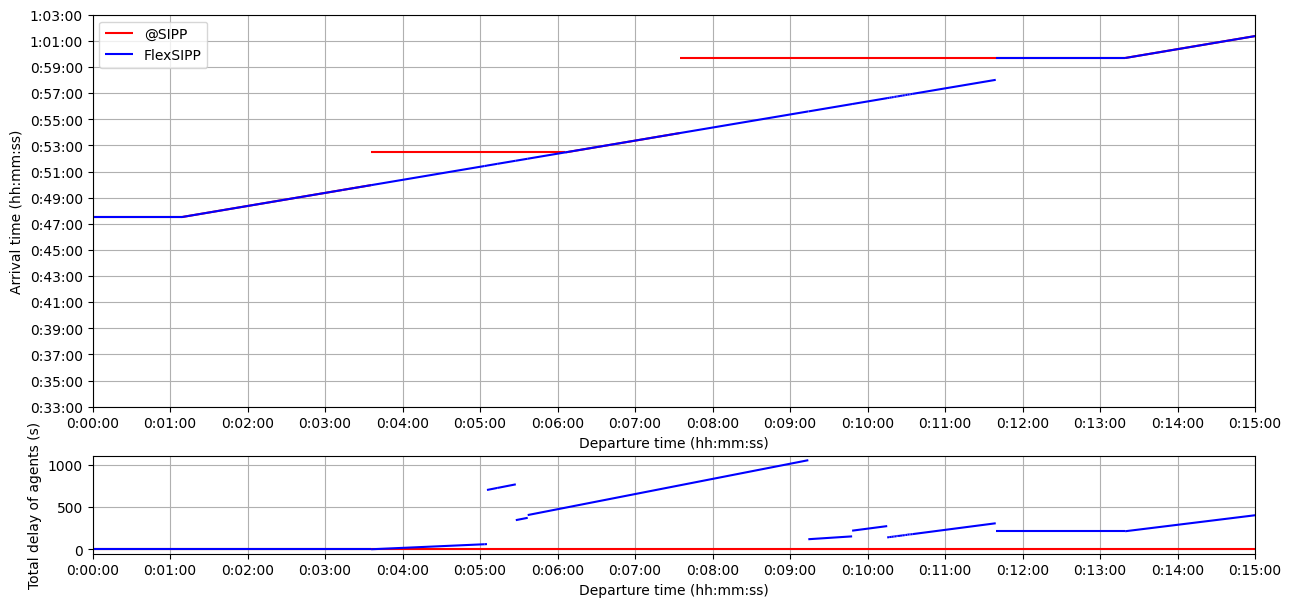

In [33]:

tad_exp.plot(experiments, save="600o-ZL", y_offset=-1200, include_expected_arrival=False)

# Experiment Runtime
Take a route of an agent with many stops, and run from start to every stop as an experiment

## Results


### ATF Plot

### Blocking staircase diagram
Showing the route of the agent with the most stops, its quite long.


C:\Users\erick\Documents\uni\Thesis\delay-replannning\generation\safe_interval_graph.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(timedelta(seconds=ytick)) for ytick in ax.get_yticks()])


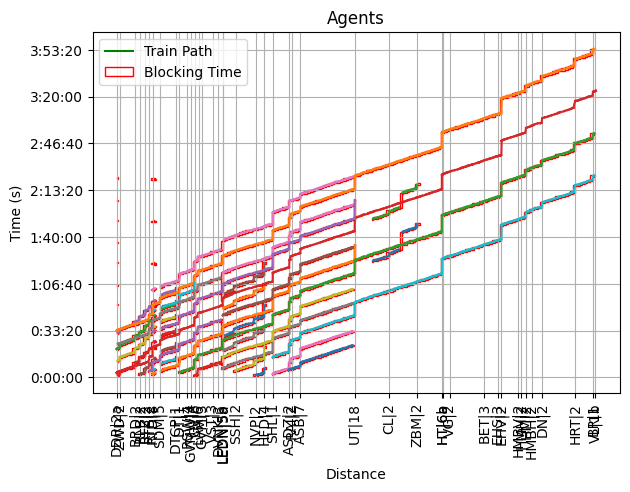

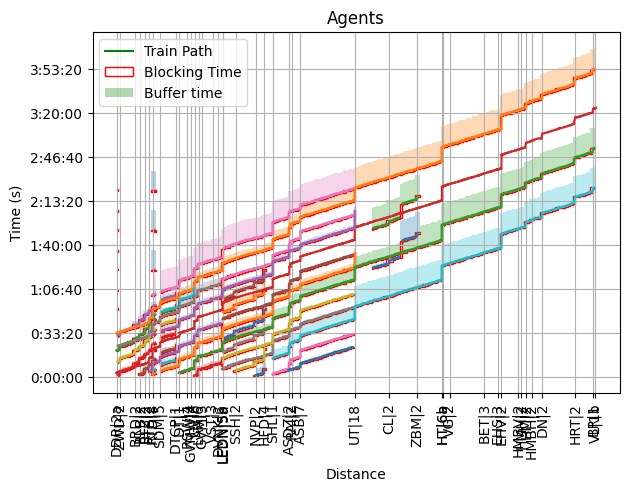

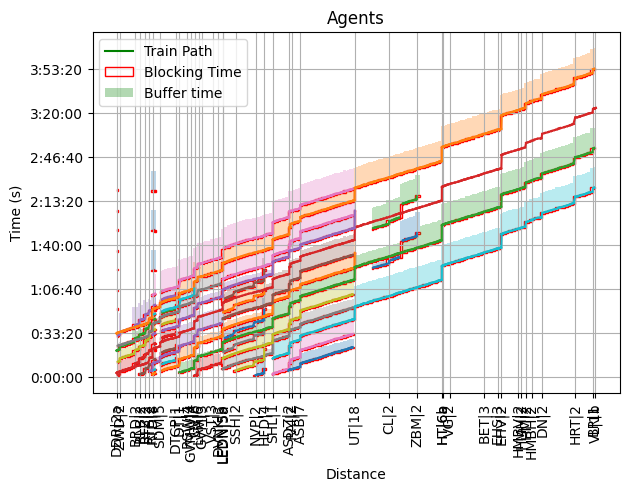

In [109]:
for exp in experiments:
    exp.s.plot(agent_id, exp.block_intervals, exp.buffer_times, exp.recovery_times, True)

### Time statistics

In [112]:
def sum_cols(df1, cols, name):
    df2 = df1.drop(columns=cols)
    df2[name] = df1[cols].sum(axis=1)
    return df2

time_df = pd.DataFrame([exp.get_running_time() for exp in experiments], index=[exp.metadata['label'] for exp in experiments])

setup_cols = ["track graph creation", "routing graph creation"]
recompute_cols = ["unsafe interval generation", "safe interval generation", "bt and crt generation", "converting routes to blocks"]
search_cols = ["FlexSIPP search time"]

time_df = sum_cols(time_df, setup_cols, "Setup Time")
time_df = sum_cols(time_df, recompute_cols, "Recompute Time")
time_df = sum_cols(time_df, search_cols, "Search Time")
time_df

,Setup Time,Recompute Time,Search Time
No flexibility,67.438534,236.065050,7.293
Buffer time,67.438534,235.538854,14.993
Recovery time,67.438534,235.782153,15.619


### Search Node Statistics


In [113]:
nodes_df = pd.DataFrame([exp.get_complexity() for exp in experiments], index=[exp.metadata['label'] for exp in experiments])

nodes_df

,nodes generated,nodes decreased,nodes expanded
No flexibility,346,53,137
Buffer time,441,59,215
Recovery time,534,33,270


### Output paths found


In [114]:
for key, value in experiments[2].results[3].items():
    delayed_trains = {i: v for i,v in enumerate(value[0][4]) if float(v[0]) > 0}
    print(f"{key.replace('r-', '')}\nearliest departure: {int(min(float(value[0][1]), float(value[0][2])) / 60)}\ndepart before: {int(float(value[0][2]) / 60)}\narrive at: {int((float(value[0][1]) + float(value[0][3])) / 60)}\ndelays trains: {delayed_trains}")

Gv|244;Gv|1822;Laa|1820;Laa|1818;Gvm|190;Gvm|170;Gvm|866;Gvm_Ledn|856;Gvm_Ledn|846;Gvm_Ledn|836;Gvm_Ledn|826;Gvm_Ledn|816;Gvm_Ledn|806;Ledn|1114;Ledn|1066;Ledn|1030;Ledn|1992;Hfd_Ledn|1990;Hfd_Ledn|1986;Hfd_Ledn|1984;Hfd_Ledn|1982;Hfd_Ledn|1980;Hfd_Ledn|1978;Hfd_Ledn|1976;Hfd_Ledn|1974;Hfd_Ledn|1972;Hfd_Ledn|1970;Hfd|1232;Hfd|1212;Hfd|1152;Hfd|1138;Hfd|1118;Hfd_Shl|1776;Hfd_Shl|1762;Shl|1086;Shl|1068;Shl|1062;Shl|1032;Asra_Shl|1740;Asra_Shl|1726;Asra|1308;Asra|1024;Asdzo|704;Asdzo|1404;Asdzo|744;Asdzo|764
earliest departure: 42
depart before: 42
arrive at: 64
delays trains: {56: ['209.505', '233.691', '1437.12'], 72: ['210.852', '235.038', '2012.68']}
Gv|244;Gv|1822;Laa|1820;Laa|1818;Gvm|190;Gvm|170;Gvm|866;Gvm_Ledn|856;Gvm_Ledn|846;Gvm_Ledn|836;Gvm_Ledn|826;Gvm_Ledn|816;Gvm_Ledn|806;Ledn|1114;Ledn|1066;Ledn|1030;Ledn|1992;Hfd_Ledn|1990;Hfd_Ledn|1986;Hfd_Ledn|1984;Hfd_Ledn|1982;Hfd_Ledn|1980;Hfd_Ledn|1978;Hfd_Ledn|1976;Hfd_Ledn|1974;Hfd_Ledn|1972;Hfd_Ledn|1970;Hfd|1232;Hfd|1212;Hfd|115

### Path statistics


In [115]:
for exp in experiments:
    print(f"Differend paths found for {exp.metadata['label']}: {sum(exp.results[2].values())}")

Differend paths found for No flexibility: 1
Differend paths found for Buffer time: 1
Differend paths found for Recovery time: 3
